In [119]:
import random
import matplotlib.pyplot as plt
from typing import List
import torch

class Bandit:
    
    def __init__(self, mean: float, name: str):
        self._mean = mean
        self._name = name

    def __str__(self):
        return self._name

    def spin(self):
        return random.gauss(self._mean, 1)
        
    def change(self):
        self._mean += random.gauss(0, 1)

In [120]:
from enum import Enum, auto

class StepSize(Enum):
    SAMPLE_AVERAGE = auto()
    CONSTANT_STEP_SIZE = auto()
    UNBIASED_COSS = auto()


class Model:
    # Model class. Remembers the state payoffs of each bandit over time.
    # Includes a chooseNext function, which decides which bandit is the next most likely to provide 
    # success. Uses epsilon probability for exploration over exploitation. 
    def __init__(self, epsilon: float, bandits: List[Bandit], alpha: float, step_size_type: StepSize = StepSize.SAMPLE_AVERAGE):
        self._step_size_type = step_size_type
        self._iter = 0
        self._alpha = alpha
        self._o_n = {bandit: 0.0 for bandit in bandits}
        self._eps = epsilon
        self._bandits = bandits
        self._iters = {bandit: 0.0 for bandit in bandits}
        self._q = {bandit: 0.0 for bandit in bandits}
        self._rewards = {bandit: 0.0 for bandit in bandits}
        self._top_bandit = (None, 0)

    # find the best bandit, constant step size
    # use tensors
    def _pick(self) -> Bandit:
        if random.random() <= self._eps or self._top_bandit[0] is None: 
            retval = self._bandits[random.randrange(len(self._bandits))]
        else: 
            retval = self._top_bandit[0]    
        
        return retval
    
    def _get_step_size(self, bandit: Bandit):
        if self._step_size_type == StepSize.CONSTANT_STEP_SIZE:
            return self._alpha
        elif self._step_size_type == StepSize.SAMPLE_AVERAGE:
            return 1 / (self._iters[bandit])
        elif self._step_size_type == StepSize.UNBIASED_COSS:
            o_nm1 = self._o_n[bandit]
            o_n = o_nm1 + self._alpha * (1 - o_nm1)
            self._o_n[bandit] = o_n
            return self._alpha / o_n

    def _update_q(self, bandit: Bandit, value: float):
        qn = self._q[bandit] 
        step_size = self._get_step_size(bandit)
        self._q[bandit] = qn + step_size * (value - qn)

        if qn > self._top_bandit[1]:
            # print(f"updated top bandit to {bandit}")
            self._top_bandit = (bandit, qn)

    def pick_and_spin(self):
        bandit = self._pick()
        self._iters[bandit] = self._iters[bandit] + 1
        value = bandit.spin()
        self._update_q(bandit, value)
        return value

    def change_all(self):
        for bandit in self._bandits:
            bandit.change()

    def evaluate(self):
        print("==============")
        print(f"Evaluation status of {len(self._bandits)} bandits:")
        for record in self._records.items():
            print(f"Bandit {record[0]} has expected value of {record[1]._num} over {record[1]._denom} tries. Value: {record[1].get_value()}")
        print("---------")
        print(f"Top bandit is {self._top_bandit[0]} with a value of {self._top_bandit[1]}")
        print("==============")


In [121]:
def evaluate_epsilon(epsilon, step_size):
    values = torch.zeros((2000, 10000))
    for i in range(2000):
        reward = random.gauss(0, 1)
        bandits = [
            Bandit(reward, "bandit1"),
            Bandit(reward, "bandit2"),
            Bandit(reward, "bandit3"),
            Bandit(reward, "bandit4"),
            Bandit(reward, "bandit5"),
            Bandit(reward, "bandit6"),
            Bandit(reward, "bandit7"),
            Bandit(reward, "bandit8"),
            Bandit(reward, "bandit9"),
            Bandit(reward, "bandit10")
        ]
        model = Model(epsilon, bandits, 0.1, step_size)
        for j in range(10000):
            values[i, j] = (model.pick_and_spin())
            model.change_all()
    return values

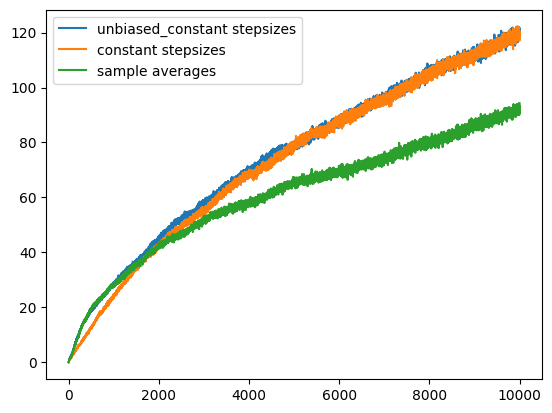

In [122]:
values_unbiased_constant_stepsize = evaluate_epsilon(0.1, StepSize.UNBIASED_COSS)
values_constant_stepsize = evaluate_epsilon(0.1, StepSize.CONSTANT_STEP_SIZE)
values_sample_averages = evaluate_epsilon(0.1, StepSize.SAMPLE_AVERAGE)
plt.plot(values_unbiased_constant_stepsize.mean(0), label='unbiased_constant stepsizes')
plt.plot(values_constant_stepsize.mean(0), label='constant stepsizes')
plt.plot(values_sample_averages.mean(0), label='sample averages')
plt.legend()